In [1]:
%pip install scikit-learn-intelex

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pyade-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 7.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install -U evolutionary_forest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.3/146.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.1/256.1 kB 17.5 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - \ | / done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 70.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - \ done
  Created wheel for sklearn2pmml: filename=sklearn2pmml-0.94.0-py3-none-any.whl size=6496034 sha256=d81db1f69d369249ca00335eea0ac2694560267999cc03d26950b632c5d57d00
  Stored in directory: /root/.cache/pip/wheels/0f/b4/a7/73fded3e1d20087f30218eed38728ff06c0efb45e765b54644
  Created wheel for smt: filename=smt-1.3.0-cp310-cp310-linux_x86_64.whl size=245960 sha256=888a2a47e7cc75dfed17d069d934134ac66464643734555c43faefe6f837f084
  Stored in directory: /root/.cache/pip/wheel

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.datasets import load_diabetes, make_friedman1
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from evolutionary_forest.forest import EvolutionaryForestRegressor
from evolutionary_forest.utils import get_feature_importance, plot_feature_importance, feature_append

/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

In [6]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


In [7]:
home_directory = '/kaggle/input/playground-series-s3e17/'
train = pd.read_csv(home_directory+'train.csv')
test = pd.read_csv(home_directory+'test.csv')
sample_submission = pd.read_csv(home_directory+'sample_submission.csv')

# Current Use Case

# Data Type Cleaning
- removing categorical columns

In [8]:
X = train.copy()
X['Type_ordinal'] = X['Type'].map({'L':1, 'M':2, 'H':3})
X.drop(['id','Product ID','Type'], axis=1, inplace=True)

# Columns name cleaning

In [9]:
# X.columns = [''.join(filter(str.isalnum, i)).lower() for i in X.columns]
X.columns = [i.replace(' ','').replace("[",'').replace("]",'').lower() for i in X.columns]


# Data Prep

In [10]:
y = X.pop('machinefailure')
# Split dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
x_train

,airtemperaturek,processtemperaturek,rotationalspeedrpm,torquenm,toolwearmin,twf,hdf,pwf,osf,rnf,type_ordinal
131389,302.5,311.1,1389,53.5,135,0,0,0,0,0,1
50495,301.0,312.0,1675,30.7,113,0,0,0,0,0,1
37400,300.7,310.5,1541,36.0,194,0,0,0,0,0,1
89228,303.3,312.6,1611,35.0,125,0,0,0,0,0,3
36393,298.6,309.5,1426,45.4,36,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...
41993,298.2,307.9,1510,47.9,2,0,0,0,0,0,1
97639,297.4,308.7,1798,36.2,135,0,0,0,0,0,2
95939,301.8,310.9,1359,54.6,182,0,0,0,1,0,1
117952,298.1,310.2,1517,40.7,148,0,0,0,0,0,2


In [12]:
y

0         0
1         0
2         0
3         0
4         0
         ..
136424    0
136425    0
136426    0
136427    0
136428    0
Name: machinefailure, Length: 136429, dtype: int64

In [13]:
help(EvolutionaryForestRegressor)

Help on class EvolutionaryForestRegressor in module evolutionary_forest.forest:

class EvolutionaryForestRegressor(sklearn.base.RegressorMixin, sklearn.base.TransformerMixin, sklearn.base.BaseEstimator, evolutionary_forest.strategies.surrogate_model.SurrogateModel, evolutionary_forest.strategies.space_partition.SpacePartition, evolutionary_forest.strategies.estimation_of_distribution.EstimationOfDistribution)
 |  EvolutionaryForestRegressor(n_pop=50, n_gen=20, verbose=False, max_height=8, min_height=0, basic_primitives=True, normalize=True, select='AutomaticLexicaseFast', gene_num=5, mutation_scheme='uniform', ensemble_size=100, external_archive=None, original_features=False, diversity_search='None', cross_pb=0.5, mutation_pb=0.1, second_layer=None, ensemble_selection=None, test_fun=None, bootstrap_training=False, mean_model=False, early_stop=-1, min_samples_leaf=1, base_learner='Random-DT', score_func='R2', max_tree_depth=None, environmental_selection=None, pre_selection=None, eager_t

In [14]:
# Train Random Forest
# r = RandomForestRegressor()
# r.fit(x_train, y_train)
# print(r2_score(y_test, r.predict(x_test)))

# Train Evolutionary Forest
r = EvolutionaryForestRegressor(max_height=5, normalize=True, select='AutomaticLexicase',
                                gene_num=10, boost_size=100, n_gen=20, n_pop=200, cross_pb=1,
                                base_learner='Random-DT', verbose=True, n_process=1)
r.fit(x_train, y_train)
print(r2_score(y_test, r.predict(x_test)))

data shape (109143, 11) (109143,)
   	      	                                                          fitness                                                           	                                  size                                  
   	      	----------------------------------------------------------------------------------------------------------------------------	------------------------------------------------------------------------
gen	nevals	25%         	75%         	avg         	gen	max         	median      	min          	nevals	std         	25%	75%	avg 	gen	max	median	min	nevals	std     
0  	200   	[0.23961265]	[0.45681666]	[0.33000566]	0  	[0.60671606]	[0.41912099]	[-0.23243672]	200   	[0.17287068]	3  	4  	3.85	0  	5  	4     	3  	200   	0.606218
defaultdict(<class 'int'>, {'1': 200})
P value of different population 0.23690664278331564
AQ(type_ordinal, hdf)
Add(twf, hdf)
AQ(pwf, rotationalspeedrpm)
Mul(Add(-1, twf), Mul(pwf, rotationalspeedrpm))
Add(pwf, rotationalsp

In [15]:
r

EvolutionaryForestRegressor(basic_primitives='Add,Sub,Mul,AQ', boost_size=100,
                            cross_pb=1, gene_num=10, mab_parameter={},
                            map_elite_parameter={}, max_height=5, n_pop=200,
                            select='AutomaticLexicase', verbose=True)

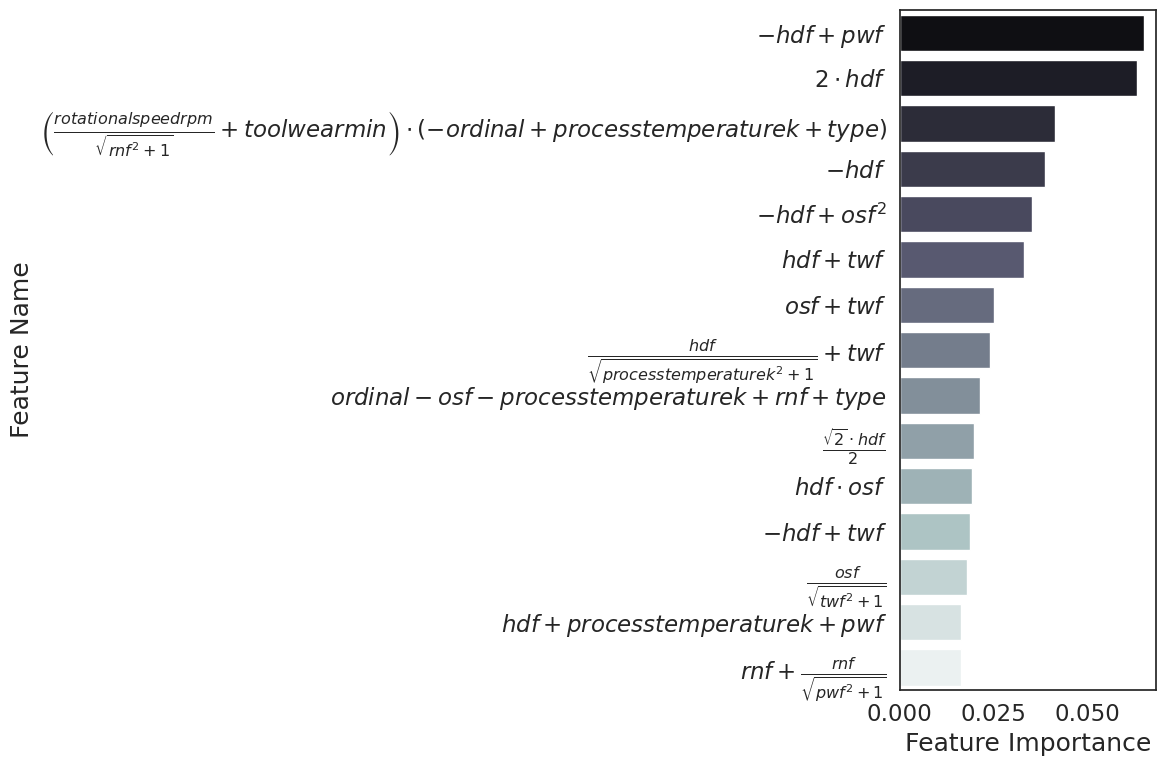

In [16]:
feature_importance_dict = get_feature_importance(r)
plot_feature_importance(feature_importance_dict)

In [17]:
# Synthesize new features
code_importance_dict = get_feature_importance(r, simple_version=False)
top_features = list(code_importance_dict.keys())[:len(code_importance_dict) // 2]
new_train = feature_append(r, pd.DataFrame(r.x_scaler.transform(x_train), columns=x_train.columns), top_features, only_new_features=True)
new_test = feature_append(r, r.x_scaler.transform(x_test), top_features, only_new_features=True)

# Train a new model on synthesized features
new_r = RandomForestRegressor()
new_r.fit(new_train, y_train)
print(r2_score(y_test, new_r.predict(new_test)))

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


0.7767550779240833


# Copies of code from the repo
https://github.com/hengzhe-zhang/EvolutionaryForest/tree/master

In [18]:
tmp_name = X.columns
tmp_name

Index(['airtemperaturek', 'processtemperaturek', 'rotationalspeedrpm',
       'torquenm', 'toolwearmin', 'twf', 'hdf', 'pwf', 'osf', 'rnf',
       'type_ordinal'],
      dtype='object')

In [19]:
# import random
# import string
# import numpy as np
# import pandas as pd
# from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor
# from sklearn.datasets import load_diabetes, make_friedman1
# from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
# from sklearn.metrics import r2_score
# from sklearn.model_selection import train_test_split
# from xgboost import XGBRegressor

# from evolutionary_forest.forest import EvolutionaryForestRegressor
# from evolutionary_forest.utils import get_feature_importance, plot_feature_importance, feature_append

# random.seed(0)
# np.random.seed(0)

# # Load dataset
# # X, y = load_diabetes(return_X_y=True)
# # x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# # Generate dataset
# X, y = make_friedman1(n_samples=100, n_features=5, random_state=0)

# # Convert numpy arrays to pandas dataframe
# X = pd.DataFrame(X, columns=list(string.ascii_uppercase[:X.shape[1]]))
# y = pd.DataFrame(y, columns=['Target'])

# # Split dataset
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
# # Train Random Forest
# # r = RandomForestRegressor()
# # r.fit(x_train, y_train)
# # print(r2_score(y_test, r.predict(x_test)))

# # Train Evolutionary Forest
# r = EvolutionaryForestRegressor(max_height=5, normalize=True, select='AutomaticLexicase',
#                                 gene_num=10, boost_size=100, n_gen=20, n_pop=200, cross_pb=1,
#                                 base_learner='Random-DT', verbose=True, n_process=1)
# r.fit(x_train, y_train)
# print(r2_score(y_test, r.predict(x_test)))

In [21]:
# feature_importance_dict = get_feature_importance(r)
# plot_feature_importance(feature_importance_dict)

In [22]:
# # Synthesize new features
# code_importance_dict = get_feature_importance(r, simple_version=False)
# top_features = list(code_importance_dict.keys())[:len(code_importance_dict) // 2]
# new_train = feature_append(r, pd.DataFrame(r.x_scaler.transform(x_train), columns=x_train.columns), top_features, only_new_features=True)
# new_test = feature_append(r, r.x_scaler.transform(x_test), top_features, only_new_features=True)

# # Train a new model on synthesized features
# new_r = RandomForestRegressor()
# new_r.fit(new_train, y_train)
# print(r2_score(y_test, new_r.predict(new_test)))

In [23]:
# new_train

In [24]:
# regressor_list = ['RF', 'ET', 'AdaBoost', 'GBDT', 'DART', 'XGBoost', 'LightGBM', 'CatBoost']

# # Normalize training and testing data
# x_train, x_test = r.x_scaler.transform(x_train), r.x_scaler.transform(x_test)

# # Get feature importance and select top features
# code_importance_dict = get_feature_importance(r, simple_version=False)
# top_features = list(code_importance_dict.keys())[:len(code_importance_dict.keys()) // 2]

# # Replace the original dataset with new features
# new_train = feature_append(r, x_train, top_features, only_new_features=True)
# new_test = feature_append(r, x_test, top_features, only_new_features=True)

# # Define regressors
# regressor_dict = {
#     'RF': RandomForestRegressor(n_estimators=200, n_jobs=-1),
#     'ET': ExtraTreesRegressor(n_estimators=200, n_jobs=-1),
#     'AdaBoost': AdaBoostRegressor(n_estimators=200),
#     'GBDT': GradientBoostingRegressor(n_estimators=200),
#     'DART': LGBMRegressor(n_jobs=1, n_estimators=200, boosting_type='dart',
#                             xgboost_dart_mode=True),
#     'XGBoost': XGBRegressor(n_jobs=1, n_estimators=200),
#     'LightGBM': LGBMRegressor(n_jobs=1, n_estimators=200),
#     'CatBoost': CatBoostRegressor(n_estimators=200, thread_count=1,
#                                     verbose=False, allow_writing_files=False),
# }

# scores_base = []
# scores_enhanced = []

# # Train and evaluate regressors on original and new features
# for regr in regressor_list:
#     regressor = regressor_dict[regr]
    
#     # Train on original features
#     regressor.fit(x_train, y_train)
#     score = r2_score(y_test, regressor.predict(x_test))
#     scores_base.append((regr, score))

#     # Train on new features
#     regressor.fit(new_train, y_train)
#     score = r2_score(y_test, regressor.predict(new_test))
#     scores_enhanced.append((regr, score))

# # Calculate mean scores for each algorithm
# base_frame = pd.DataFrame(scores_base, columns=['algorithm', 'score'])
# print(base_frame.groupby(['algorithm']).mean())

# improved_frame = pd.DataFrame(scores_enhanced, columns=['algorithm', 'score'])
# print(improved_frame.groupby(['algorithm']).mean())

# # Calculate the improvement in scores
# base_score = base_frame.groupby(['algorithm']).mean()
# improved_score = improved_frame.groupby(['algorithm']).mean()
# print(improved_score - base_score)

In [25]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set(style="white", font_scale=1.5)
# width = 0.4
# fig, ax = plt.subplots(figsize=(10, 6))

# # Plot scores for original features
# ax.bar(base_score.index, base_score['score'], width, label='Original Features')

# # Calculate score differences
# difference = improved_score['score'] - base_score['score']

# # Choose bar colors based on score improvement
# colors = np.where(difference > 0, 'r', 'y')

# # Plot score differences for constructed features
# ax.bar(base_score.index, difference, width, bottom=base_score['score'],
#        label='Constructed Features', color=colors)

# # Set labels and title
# ax.set_ylabel('Score ($R^2$)')
# ax.set_title('Effect of Feature Construction')
# ax.legend()

# # Format the x-axis labels
# plt.xticks(rotation=45)
# plt.tight_layout()

# # Show the plot
# plt.show()

In [26]:
import sys
sys.path.insert(0, '../')

import random
import string
import pandas as pd
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from evolutionary_forest.forest import EvolutionaryForestRegressor

In [27]:
random.seed(0)
np.random.seed(0)

# Generate dataset
X, y = make_friedman1(n_samples=100, n_features=5, random_state=0)

# Convert numpy arrays to pandas dataframe
X = pd.DataFrame(X, columns=list(string.ascii_uppercase[:X.shape[1]]))
y = pd.DataFrame(y, columns=['Target'])

In [28]:
# Split dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [29]:
# Train Evolutionary Forest
r = EvolutionaryForestRegressor(max_height=5, normalize=True, select='AutomaticLexicase',
                                gene_num=10, boost_size=100, n_gen=20, n_pop=200, cross_pb=1,
                                base_learner='Random-DT', verbose=True, n_process=1)
r.fit(x_train, y_train)

data shape (80, 5) (80,)
   	      	                                                          fitness                                                           	                                  size                                  
   	      	----------------------------------------------------------------------------------------------------------------------------	------------------------------------------------------------------------
gen	nevals	25%         	75%         	avg         	gen	max         	median      	min         	nevals	std         	25%	75%	avg  	gen	max	median	min	nevals	std     
0  	200   	[0.19012237]	[0.43453516]	[0.27484596]	0  	[0.66708961]	[0.33572612]	[-0.7157414]	200   	[0.25761531]	4  	4  	3.995	0  	6  	4     	3  	200   	0.644186
defaultdict(<class 'int'>, {'1': 200})
P value of different population 0.0011436497674470886
Sub(AQ(D, B), Sub(D, C))
AQ(Add(D, B), 0)
Sub(C, A)
AQ(0, A)
AQ(C, -1)
Add(D, E)
Add(Mul(C, C), Sub(E, A))
Mul(A, E)
Sub(B, A)
Mul(Sub(E, E)

EvolutionaryForestRegressor(basic_primitives='Add,Sub,Mul,AQ', boost_size=100,
                            cross_pb=1, gene_num=10, mab_parameter={},
                            map_elite_parameter={}, max_height=5, n_pop=200,
                            select='AutomaticLexicase', verbose=True)